In [2]:
from pyspark.sql import SparkSession

# Creating a Spark session
spark = SparkSession.builder \
    .appName("Diabetes EDA") \
    .getOrCreate()

# Loading the diabetes dataset
file_path = "diabetes.csv"
diabetes_df = spark.read.csv(file_path, header=True, inferSchema=True)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/14 17:47:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
diabetes_df.createOrReplaceTempView("diabetes")


In [4]:
spark.sql("DESCRIBE diabetes").show()


+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|         Pregnancies|      int|   null|
|             Glucose|      int|   null|
|       BloodPressure|      int|   null|
|       SkinThickness|      int|   null|
|             Insulin|      int|   null|
|                 BMI|   double|   null|
|DiabetesPedigreeF...|   double|   null|
|                 Age|      int|   null|
|             Outcome|      int|   null|
+--------------------+---------+-------+



In [5]:
from pyspark.sql.types import IntegerType, DoubleType

all_columns = [col.name for col in diabetes_df.schema]
numerical_columns = [col.name for col in diabetes_df.schema if col.dataType in {IntegerType(), DoubleType()}]
categorical_columns = [col for col in all_columns if col not in numerical_columns]



In [6]:
categorical_columns

[]

In [7]:
avg_query = ", ".join([f"AVG({col}) AS mean_{col}" for col in numerical_columns])
stddev_query = ", ".join([f"STDDEV({col}) AS stddev_{col}" for col in numerical_columns])
min_query = ", ".join([f"MIN({col}) AS min_{col}" for col in numerical_columns])
max_query = ", ".join([f"MAX({col}) AS max_{col}" for col in numerical_columns])

spark.sql(f"SELECT {avg_query} FROM diabetes").show()
spark.sql(f"SELECT {stddev_query} FROM diabetes").show()
spark.sql(f"SELECT {min_query} FROM diabetes").show()
spark.sql(f"SELECT {max_query} FROM diabetes").show()


+------------------+------------+------------------+------------------+-----------------+------------------+-----------------------------+------------------+------------------+
|  mean_Pregnancies|mean_Glucose|mean_BloodPressure|mean_SkinThickness|     mean_Insulin|          mean_BMI|mean_DiabetesPedigreeFunction|          mean_Age|      mean_Outcome|
+------------------+------------+------------------+------------------+-----------------+------------------+-----------------------------+------------------+------------------+
|3.8450520833333335|120.89453125|       69.10546875|20.536458333333332|79.79947916666667|31.992578124999977|           0.4718763020833327|33.240885416666664|0.3489583333333333|
+------------------+------------+------------------+------------------+-----------------+------------------+-----------------------------+------------------+------------------+



23/08/14 17:49:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+-----------------+--------------------+--------------------+------------------+-----------------+-------------------------------+------------------+-----------------+
|stddev_Pregnancies|   stddev_Glucose|stddev_BloodPressure|stddev_SkinThickness|    stddev_Insulin|       stddev_BMI|stddev_DiabetesPedigreeFunction|        stddev_Age|   stddev_Outcome|
+------------------+-----------------+--------------------+--------------------+------------------+-----------------+-------------------------------+------------------+-----------------+
|  3.36957806269887|31.97261819513622|  19.355807170644777|  15.952217567727642|115.24400235133803|7.884160320375441|              0.331328595012775|11.760231540678689|0.476951377242799|
+------------------+-----------------+--------------------+--------------------+------------------+-----------------+-------------------------------+------------------+-----------------+

+---------------+-----------+-----------------+-----------------

In [8]:
missing_query = ", ".join([f"SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS missing_{col}" for col in numerical_columns])
spark.sql(f"SELECT {missing_query} FROM diabetes").show()


+-------------------+---------------+---------------------+---------------------+---------------+-----------+--------------------------------+-----------+---------------+
|missing_Pregnancies|missing_Glucose|missing_BloodPressure|missing_SkinThickness|missing_Insulin|missing_BMI|missing_DiabetesPedigreeFunction|missing_Age|missing_Outcome|
+-------------------+---------------+---------------------+---------------------+---------------+-----------+--------------------------------+-----------+---------------+
|                  0|              0|                    0|                    0|              0|          0|                               0|          0|              0|
+-------------------+---------------+---------------------+---------------------+---------------+-----------+--------------------------------+-----------+---------------+



In [9]:
selected_features = [('Glucose', 'Insulin'), ('Age', 'Pregnancies'), ('BMI', 'SkinThickness')]

for feature_pair in selected_features:
    correlation = spark.sql(f"SELECT CORR({feature_pair[0]}, {feature_pair[1]}) AS correlation FROM diabetes").collect()[0][0]
    print(f"Correlation between {feature_pair[0]} and {feature_pair[1]}: {correlation}")


Correlation between Glucose and Insulin: 0.3313571099202092
Correlation between Age and Pregnancies: 0.5443412284023394
Correlation between BMI and SkinThickness: 0.39257320415903835


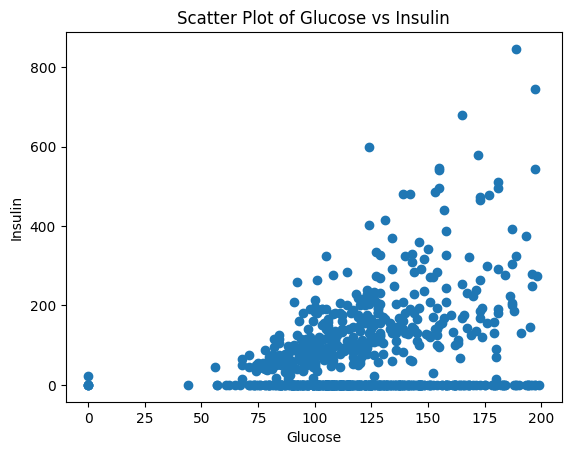

Image saved at images/Glucose_vs_Insulin.png


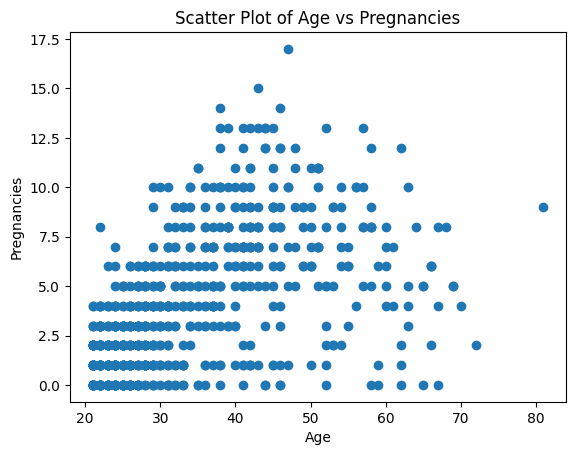

Image saved at images/Age_vs_Pregnancies.png


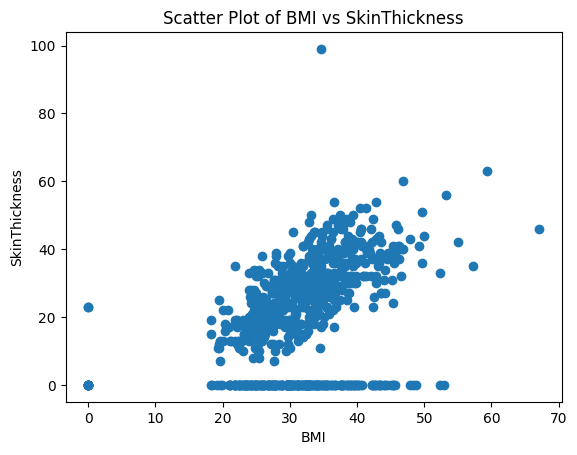

Image saved at images/BMI_vs_SkinThickness.png


In [11]:
import matplotlib.pyplot as plt
import os

# Create an "images" folder if it doesn't exist
image_folder = 'images'
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

for feature_pair in selected_features:
    x = diabetes_df.select(feature_pair[0]).rdd.flatMap(lambda x: x).collect()
    y = diabetes_df.select(feature_pair[1]).rdd.flatMap(lambda x: x).collect()
    plt.scatter(x, y)
    plt.xlabel(feature_pair[0])
    plt.ylabel(feature_pair[1])
    plt.title(f"Scatter Plot of {feature_pair[0]} vs {feature_pair[1]}")
    
    # Save the plot as an image in the "images" folder
    image_name = f"{feature_pair[0]}_vs_{feature_pair[1]}.png"
    image_path = os.path.join(image_folder, image_name)
    plt.savefig(image_path)
    
    plt.show()
    print(f"Image saved at {image_path}")



In [12]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
transformed_data = assembler.transform(diabetes_df)

pca = PCA(k=3, inputCol="features", outputCol="pca_features")
model = pca.fit(transformed_data)
result = model.transform(transformed_data)

result.select("pca_features").show()

23/08/14 17:59:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/08/14 17:59:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+--------------------+
|        pca_features|
+--------------------+
|[18.0426617386871...|
|[11.3984444425695...|
|[19.1266815709902...|
|[104.834116538176...|
|[183.501066557666...|
|[12.7787991357955...|
|[98.1082366300488...|
|[11.6194252339339...|
|[562.623610173834...|
|[13.5634600146315...|
|[12.6517498532584...|
|[18.0151485555426...|
|[15.0403574844043...|
|[861.231220920858...|
|[192.514681863700...|
|[10.0741344192853...|
|[244.696702042400...|
|[11.9475414464639...|
|[95.7814624231616...|
|[109.905753938484...|
+--------------------+
only showing top 20 rows



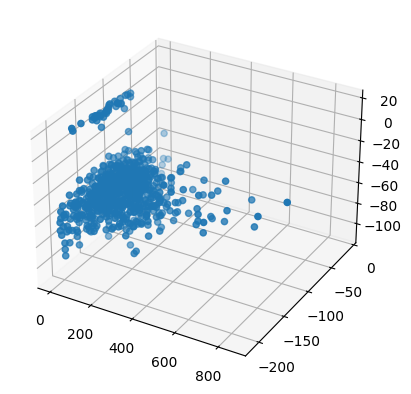

Image saved at images/3d_scatter_plot.png


In [13]:
from mpl_toolkits.mplot3d import Axes3D
import os

# Create an "images" folder if it doesn't exist
image_folder = 'images'
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

pca_values = result.select("pca_features").rdd.map(lambda x: x[0]).collect()
x = [v[0] for v in pca_values]
y = [v[1] for v in pca_values]
z = [v[2] for v in pca_values]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

# Save the plot as an image in the "images" folder
image_path = os.path.join(image_folder, '3d_scatter_plot.png')
plt.savefig(image_path)

plt.show()

print(f"Image saved at {image_path}")
